# Load water level data from DMI

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

C:\Users\JAN\AppData\Local\Temp/ipykernel_21332/396824514.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


In [3]:
from tsod.detectors import CombinedDetector, RangeDetector, DiffDetector, RollingStandardDeviationDetector
from tsod.hampel import HampelDetector

In [4]:
file_path = os.path.join("..", "tests", "data", "Ballen_20150218-20201222.csv")
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [5]:
data = df.water_level

<AxesSubplot:>

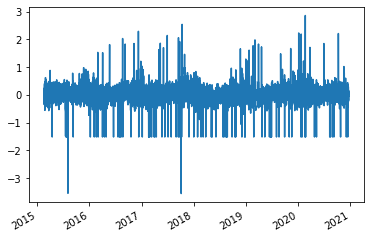

In [6]:
data.plot()

# Detect anomalies outside manually set range

In [7]:
range_anomalies = RangeDetector(-1, 1.3).detect(data)

<AxesSubplot:title={'center':'Anomalies detected: 1254'}>

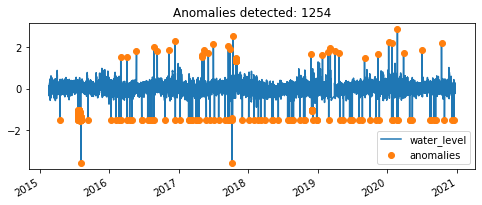

In [8]:
detected = data.to_frame()
detected["anomalies"] = data[range_anomalies.values]
detected.plot(style=['-', 'o'], figsize=(8,3), title=f"Anomalies detected: {range_anomalies.sum()}")

In [9]:
data_clean = data.copy()
data_clean[range_anomalies.values] = np.nan

# Detect anomalies outside automatically set range

In [10]:
N = 1000
normal_data, test_data = data[:N], data[N:]

In [11]:
anomaly_detector = CombinedDetector([RangeDetector(), DiffDetector()])
anomaly_detector.fit(normal_data)
detected_anomalies = anomaly_detector.detect(test_data)

In [12]:
detected_anomalies.head()

2015-02-25 12:30:00    False
2015-02-25 12:40:00    False
2015-02-25 12:50:00    False
2015-02-25 13:00:00    False
2015-02-25 13:20:00    False
dtype: bool

# Detect peaks

In [13]:
detector = RollingStandardDeviationDetector(10, 0.1)
std_anomalies = detector.detect(data)

<AxesSubplot:>

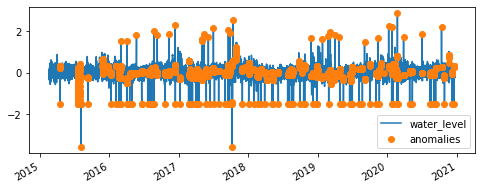

In [14]:
detected = data.to_frame()
detected["anomalies"] = data[std_anomalies.values]
detected.plot(style=['-', 'o'], figsize=(8,3))

# Hampel filter

The default threshold of the HampelDetector is 3, which means that a sample that deviates by more than three times of the rolling window's standard deviation is marked as an anomaly. **Increasing** the threshold marks **more** samples as anomalies, **decreasing** the threshold marks **fewer**.

In [16]:
detector = HampelDetector(window_size=20, threshold=3)

In [17]:
anomalies = detector.detect(data)

<AxesSubplot:title={'center':'Anomalies detected: 287'}>

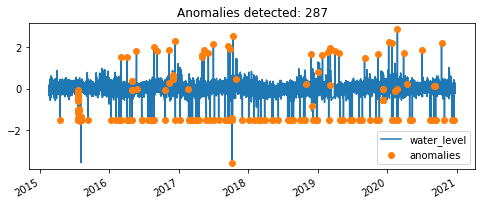

In [18]:
detected = data.to_frame()
detected["anomalies"] = data[anomalies]
detected.plot(style=['-', 'o'], figsize=(8,3), title=f'Anomalies detected: {sum(anomalies)}')